In [1]:
%matplotlib inline


Audio Feature Augmentation
====================


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [3]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------

import os
import requests

import librosa
import matplotlib.pyplot as plt


_SAMPLE_DIR = "_sample_data"

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

SpecAugment
-----------

`SpecAugment <https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html>`__
is a popular spectrogram augmentation technique.

``torchaudio`` implements ``TimeStretch``, ``TimeMasking`` and
``FrequencyMasking``.

TimeStretch
~~~~~~~~~~




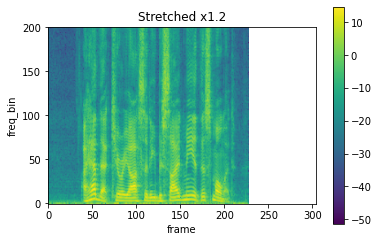

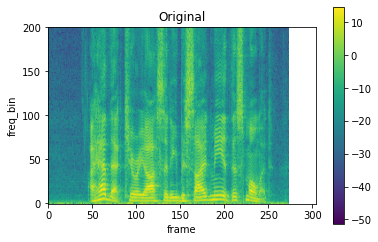

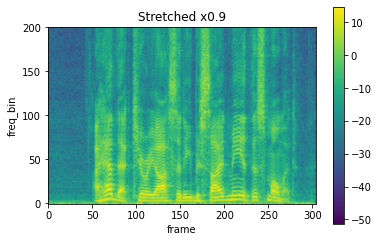

In [4]:
spec = get_spectrogram(power=None)
stretch = T.TimeStretch()

rate = 1.2
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect='equal', xmax=304)

rate = 0.9
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

TimeMasking
~~~~~~~~~~~




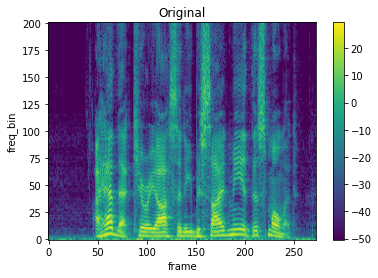

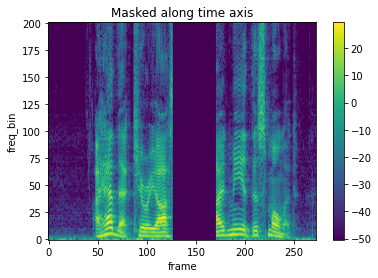

In [5]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

FrequencyMasking
~~~~~~~~~~~~~~~~




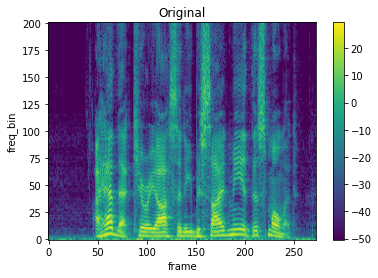

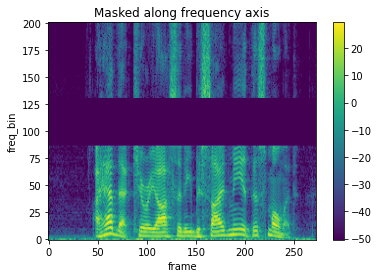

In [6]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")